<a href="https://colab.research.google.com/github/falseywinchnet/PicoGPT/blob/main/NewGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#copyright joshuah.rainstar@gmail.com 2025
#MIT with attribution

import math
import copy
from dataclasses import dataclass
from typing import Optional, Tuple, List

import torch
import torch.nn as nn
import torch.nn.functional as F

class RoPE(nn.Module):
    """Rotary Positional Embeddings."""
    def __init__(self, dim, max_len=4096):
        super().__init__()
        self.dim = dim
        inv_freq = 1.0 / (10000 ** (torch.arange(0, dim, 2).float() / dim))
        t = torch.arange(max_len).float()
        freqs = torch.einsum('i,j->ij', t, inv_freq)
        self.register_buffer('cos', freqs.cos())
        self.register_buffer('sin', freqs.sin())

    def forward(self, x):
        # x: (B, H, T, D)
        seq_len = x.shape[2]
        cos = self.cos[:seq_len, :].unsqueeze(0).unsqueeze(0)
        sin = self.sin[:seq_len, :].unsqueeze(0).unsqueeze(0)
        x1 = x[..., 0::2]
        x2 = x[..., 1::2]
        return torch.cat((-x2 * sin + x1 * cos, x1 * sin + x2 * cos), dim=-1)

class ConvexSoftmax(nn.Module):
    """Convex LSE (Float32 Precision)."""
    def forward(self, scores):
        m, _ = scores.max(dim=-1, keepdim=True)
        y = scores - m
        ex = y.exp()
        lse = m + ex.sum(dim=-1, keepdim=True).log()
        return torch.exp(scores - lse)

class BiasedWedge(nn.Module):
    """
    Symplectic Geometry with an Escape Hatch.
    S = (A - A^T) + D
    """
    def __init__(self, head_dim, total_heads):
        super().__init__()
        self.head_dim = head_dim
        self.total_heads = total_heads

        # 1. Shared Skew (Global Twist): (D, D)
        self.A = nn.Parameter(torch.zeros(head_dim, head_dim))

        # 2. Identity Bias (Local Preservation): (TotalHeads, D)
        self.id_bias = nn.Parameter(torch.zeros(total_heads, head_dim))

    def forward(self, x):
        # x: (B, TotalHeads, T, D)

        # Construct S
        skew = self.A - self.A.transpose(-1, -2) # (D, D)
        diag = torch.diag_embed(self.id_bias)      # (H, D, D)
        S = skew + diag # Broadcasts to (H, D, D)

        # Apply Flow: x @ S
        # USE EINSUM TO PREVENT BROADCASTING ERRORS
        # b: Batch
        # h: TotalHeads (Matches S dim 0)
        # t: Time (Ignored by S)
        # d: Input Dim (Contracted)
        # e: Output Dim
        flow = torch.einsum('bhtd,hde->bhte', x, S)

        return x + flow

class Attention(nn.Module):
    def __init__(self, d_model, n_head, k_retrieval: int = 4):
        super().__init__()
        self.d_model = d_model
        # System Hierarchy
        assert d_model % n_head == 0, "d_model must be divisible by n_heads"
        self.n_sub_heads = n_head
        self.n_branches = 4
        self.head_dim = d_model//n_head

        # Unified Head Dimension
        self.n_total_heads = self.n_branches * n_head

        self.scale = self.head_dim ** -0.5
        self.k_retrieval = k_retrieval

        # --- 1. Projections ---
        self.W_K = nn.Linear(d_model, d_model, bias=True)
        self.W_Q_all = nn.Linear(d_model, d_model * self.n_branches, bias=False)

        # --- 2. Geometry ---
        self.wedge = BiasedWedge(self.head_dim, self.n_total_heads)
        self.rope = RoPE(self.head_dim)

        # --- 3. Sink Parameters ---
        self.sink_scalars = nn.Parameter(torch.zeros(self.n_total_heads, 1, 1))
        self.v_nulls = nn.Parameter(torch.zeros(self.n_branches, d_model))

        # --- 4. V network: maps marker (Dh) -> value (Dh)
        # This takes the "marker" (superposition of K) and hallucinates the value
        self.V_net = nn.Sequential(
            nn.Linear(self.head_dim, 4 * self.head_dim),
            nn.GELU(),
            nn.Linear(4 * self.head_dim, self.head_dim),
        )

        # --- 5. Output ---
        self.W_O_params = nn.Parameter(torch.empty(self.n_branches, d_model, d_model))
        self.W_O_bias = nn.Parameter(torch.zeros(self.n_branches, d_model))

        nn.init.xavier_uniform_(self.W_O_params)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, A,X):
        B, T, C = A.shape
        H_tot = self.n_total_heads
        N_br = self.n_branches
        N_sh = self.n_sub_heads
        Dh = self.head_dim
        K_top = min(self.k_retrieval, T)
        # 1. Projections
        # Q: (B, T, TotalHeads, Dh) -> (B, TotalHeads, T, Dh)
        q = self.W_Q_all(A).view(B, T, H_tot, Dh).permute(0, 2, 1, 3)

        # K: content-based key templates
        k_base = self.W_K(X)
        k_base_u = k_base.view(B, T, N_sh, Dh).permute(0, 2, 1, 3)
        k = k_base_u.repeat(1, N_br, 1, 1) # (B, H_tot, T, Dh)

        # 2. Geometry on Q, K
        q = self.wedge(q)
        k = self.wedge(k)

        q = self.rope(q)
        k = self.rope(k)

        # 3. Attention scores & mask
        # attn_scores: (B, H_tot, T, T)
        attn_scores = (q @ k.transpose(-2, -1)) * self.scale
        mask = torch.triu(torch.ones(T, T, device=A.device), diagonal=1).bool()
        attn_scores.masked_fill_(mask, float('-inf'))

        # Sinks
        sinks = self.sink_scalars.view(1, H_tot, 1, 1).expand(B, -1, T, -1)
        attn_scores_full = torch.cat([attn_scores, sinks], dim=-1)
        probs_full = self.softmax(attn_scores_full)

        # Split tokens vs sink mass
        probs_tokens = probs_full[..., :T]   # (B, H_tot, T, T)
        probs_sink   = probs_full[..., T:]   # (B, H_tot, T, 1)

        # 4. Build markers from K via top-K retrieval
        # vals, idxs: (B, H_tot, T, K_top)
        vals, idxs = probs_tokens.topk(K_top, dim=-1)

        # Normalized weights for the retrieved keys
        weights = vals / (vals.sum(dim=-1, keepdim=True) + 1e-9)  # (B, H_tot, T, K_top)

        # --- FIX: Flatten batch dims to perform gather safely ---
        # k: (B, H_tot, T, Dh) -> (B*H_tot, T, Dh)
        k_flat = k.contiguous().view(B * H_tot, T, Dh)

        # idxs: (B, H_tot, T, K_top) -> (B*H_tot, T*K_top)
        # We flatten the query structure so we can just grab items from T
        idxs_flat = idxs.contiguous().view(B * H_tot, T * K_top)

        # Expand indices for the feature dimension
        # (B*H_tot, T*K_top, Dh)
        idxs_expanded = idxs_flat.unsqueeze(-1).expand(-1, -1, Dh)

        # Gather: (B*H_tot, T*K_top, Dh)
        k_gathered_flat = k_flat.gather(dim=1, index=idxs_expanded)

        # Reshape back to structure: (B, H_tot, T, K_top, Dh)
        k_selected = k_gathered_flat.view(B, H_tot, T, K_top, Dh)

        # Weighted sum: (B, H_tot, T, K_top, 1) * (B, H_tot, T, K_top, Dh) -> sum over K_top
        marker = (weights.unsqueeze(-1) * k_selected).sum(dim=3) # (B, H_tot, T, Dh)

        # 5. Pass markers through V_net to get value vectors
        # marker_flat: (B*H_tot*T, Dh)
        marker_flat = marker.view(B * H_tot * T, Dh)
        v_flat = self.V_net(marker_flat) # (B*H_tot*T, Dh)
        out_tokens = v_flat.view(B, H_tot, T, Dh)

        # 6. Sink contribution
        # v_nulls: (Br, D) -> (Br*Sh, Dh) -> (1, H_tot, 1, Dh)
        v_null_expanded = self.v_nulls.view(N_br * N_sh, Dh).view(1, H_tot, 1, Dh)
        out_sinks = probs_sink * v_null_expanded

        context = out_tokens + out_sinks

        # 7. Output projection & Bias
        # Recover Branch dim
        context = context.view(B, N_br, N_sh, T, Dh)
        context = context.permute(0, 1, 3, 2, 4).contiguous().view(B, N_br, T, C)

        y_proj = torch.einsum('bntc,ncd->bntd', context, self.W_O_params)
        bias = self.W_O_bias.view(1, N_br, 1, C)

        y = y_proj + bias

        return y.mean(dim=1)


class LayerNorm(nn.Module):
    def __init__(self, ndim: int, bias: bool = True):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.use_bias = bias
        if bias:
            self.bias = nn.Parameter(torch.zeros(ndim))
        else:
            self.register_parameter("bias", None)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        b = self.bias if self.use_bias else None
        return F.layer_norm(x, self.weight.shape, self.weight, b, 1e-5)



class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear( config.n_embd,4* config.n_embd, bias=config.bias)
        self.scale = math.pi / math.sqrt(3.0)
        self.ln = LayerNorm(config.n_embd*4, bias=config.bias)

        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = x**2 + 0.75*x**3
        x = self.ln(x)
        x = x * torch.sigmoid(self.scale * x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.ln_3 = LayerNorm(config.n_embd, bias=config.bias)
        self.ln_4 = LayerNorm(config.n_embd, bias=config.bias)
        self.ln_5 = LayerNorm(config.n_embd, bias=config.bias)
        self.ln_6 = LayerNorm(config.n_embd, bias=config.bias)

        self.left = Attention(config.n_embd,config.n_head)
        self.right = Attention(config.n_embd,config.n_head)

        self.mlpa = MLP(config)
        self.mlpb = MLP(config)

    def forward(self,x):
        B, T, C = x.shape
        half = C//2
        A = x[...,:half]
        B = x[...,half:]
        B = B + self.left(self.ln_1(A),self.ln_2(B))
        B = B + self.mlpa(self.ln_3(B))

        A = A + self.right(self.ln_4(B),self.ln_5(A))
        A = A + self.mlpb(self.ln_6(A))

        x = torch.cat([A,B],dim=-1)

        return x


@dataclass
class GPTConfig:
    block_size: int = 1024
    vocab_size: int = 50304 # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64 for efficiency
    n_layer: int = 12
    n_head: int = 12
    n_embd: int = 768
    dropout: float = 0.0
    bias: bool = True # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster

from torch.utils.checkpoint import checkpoint

class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config
        # Base noise seed (learned) for map generation

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_q = LayerNorm(config.n_embd, bias=config.bias),
            ln_f = LayerNorm(config.n_embd, bias=config.bias),
        ))
        self.synth = MLP(config)


        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        # report number of parameters
        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))

    def get_num_params(self, non_embedding=True):
        """
        Return the number of parameters in the model.
        For non-embedding count (default), the position embeddings get subtracted.
        The token embeddings would too, except due to the parameter sharing these
        params are actually used as weights in the final layer, so we include them.
        """
        n_params = sum(p.numel() for p in self.parameters())
        return n_params


    def forward(self, idx, targets=None):
        device = idx.device
        b, T = idx.size()
        tok_emb = self.transformer.wte(idx)
        q = self.transformer.ln_q(self.synth(torch.ones_like(tok_emb)))
        x = torch.cat([tok_emb,q],dim=-1)

        # forward the GPT model itself
        for block in self.transformer.h:
            x  = checkpoint(block, x, use_reentrant=False)


        A = x[...,:self.config.n_embd]


        x = self.transformer.ln_f(A)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)

            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)

        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss

In [2]:
import requests, os

base_url = "https://huggingface.co/datasets/cambridge-climb/BabyLM/resolve/main/clean/10M/"
target_dir = "./babylm_10m_cleaned"
os.makedirs(target_dir, exist_ok=True)

file_names = [
    "aochildes.txt",
    "cbt.txt",
    "children_stories.txt",
    "gutenberg.txt",
    "qed.txt",
    "simple_wikipedia.txt",
    "switchboard.txt",
    "wikipedia.txt"
]

# Optional addition: Shakespeare from another dataset
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/refs/heads/master/data/tinyshakespeare/input.txt"
shakespeare_fname = "shakespeare.txt"

# Combined download logic
all_files = [(base_url + fname, fname) for fname in file_names]
all_files.append((shakespeare_url, shakespeare_fname))  # Add Shakespeare


# Download loop
for url, fname in all_files:
    out_path = os.path.join(target_dir, fname)
    print(f"📥 Downloading {fname}...")
    resp = requests.get(url)
    if resp.status_code == 200:
        with open(out_path, "w", encoding="utf-8") as f:
            f.write(resp.text)
    else:
        print(f"❌ Failed to download {fname} ({resp.status_code})")

print(f"✅ Done. Files saved to {target_dir}")

📥 Downloading aochildes.txt...
📥 Downloading cbt.txt...
📥 Downloading children_stories.txt...
📥 Downloading gutenberg.txt...
📥 Downloading qed.txt...
📥 Downloading simple_wikipedia.txt...
📥 Downloading switchboard.txt...
📥 Downloading wikipedia.txt...
📥 Downloading shakespeare.txt...
✅ Done. Files saved to ./babylm_10m_cleaned


In [3]:
import os
import pickle
import numpy as np

# === Paths ===
source_dir = "./babylm_10m_cleaned"
out_dir    = "./babylm_char_tokenized"
os.makedirs(out_dir, exist_ok=True)

file_names = [
    "shakespeare.txt"#,"aochildes.txt", "cbt.txt", "children_stories.txt", "gutenberg.txt",
    #"qed.txt", "simple_wikipedia.txt", "switchboard.txt", "wikipedia.txt"
]

# === Load and split ===
train_texts, val_texts = [], []
char_set = set()

for fname in file_names:
    with open(os.path.join(source_dir, fname), encoding="utf-8") as f:
        lines = f.readlines()
        n = len(lines)
        split = int(0.9 * n)
        train_part = "".join(lines[:split])
        val_part   = "".join(lines[split:])
        train_texts.append(train_part)
        val_texts.append(val_part)
        char_set.update(train_part)
        char_set.update(val_part)

full_train = "\n".join(train_texts)
full_val   = "\n".join(val_texts)

# === Final vocab ===
char_set = sorted(set(char_set))
vocab_chars = ["<unk>"] + [c for c in char_set if c != "<unk>"]

stoi = {ch: i for i, ch in enumerate(vocab_chars)}
itos = {i: ch for ch, i in stoi.items()}

# === Encode function ===
def encode(text):
    return [stoi.get(c, 0) for c in text]

train_ids = np.array(encode(full_train), dtype=np.uint16)
val_ids   = np.array(encode(full_val),   dtype=np.uint16)

# === Save ===
train_ids.tofile(os.path.join(out_dir, "train.bin"))
val_ids.tofile(os.path.join(out_dir, "val.bin"))

with open(os.path.join(out_dir, "meta.pkl"), "wb") as f:
    pickle.dump({
        "vocab_size": len(stoi),
        "stoi": stoi,
        "itos": itos
    }, f)

print(f"✅ Char tokenizer finalized.")
print(f"🧾 Train tokens: {len(train_ids)} | Val tokens: {len(val_ids)}")
print(f"🔤 Vocab size: {len(stoi)}")

✅ Char tokenizer finalized.
🧾 Train tokens: 1016242 | Val tokens: 99152
🔤 Vocab size: 66


In [7]:
# import os
import pickle
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch
from torch import nn
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"

# === Config ===
data_dir = "./babylm_char_tokenized"  # <- char-tokenized data
block_size = 1024
batch_size = 8

# === Load tokenizer metadata ===
with open(os.path.join(data_dir, 'meta.pkl'), 'rb') as f:
    meta = pickle.load(f)
vocab_size = meta['vocab_size']

# === Load mmap edata (char-level tokens, uint16) ===
train_ids = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
val_ids   = np.memmap(os.path.join(data_dir, 'val.bin'),   dtype=np.uint16, mode='r')

# === Efficient GPU Batch Sampler ===
class GPUBatchDataset(Dataset):
    def __init__(self, mmap_file, block_size, batch_size, device, jitter=63, p_aligned=0.5, pad_len=0):
        self.data = mmap_file
        self.block_size = block_size
        self.batch_size = batch_size
        self.device = device
        self.pad_len = int(pad_len)
        self.sample_len = self.block_size + self.pad_len  # X length
        self.total = len(self.data) - self.sample_len - 1
        self.n_blocks = self.total // self.sample_len
        self.jitter = int(jitter)          # small random offset added to aligned start
        self.p_aligned = float(p_aligned)  # mix aligned and jittered

    def __len__(self):
        return self.total // self.batch_size

    def __getitem__(self, idx):
        X = np.empty((self.batch_size, self.sample_len), dtype=np.int64)
        Y = np.empty((self.batch_size, self.block_size), dtype=np.int64)

        for i in range(self.batch_size):
            # choose a base aligned block
            base_block = np.random.randint(0, self.n_blocks)
            start = base_block * self.sample_len

            # with probability, add a small jitter (keeps cache-friendly contiguous reads)
            if np.random.rand() > self.p_aligned:
                j = np.random.randint(0, self.jitter + 1)
                start = min(start + j, self.total)  # stay in range

            X[i] = self.data[start : start + self.sample_len]
            # targets correspond to the final block_size visible steps
            Y[i] = self.data[start + 1 + self.pad_len : start + 1 + self.pad_len + self.block_size]


        return (
            torch.from_numpy(X).to(self.device, non_blocking=True),
            torch.from_numpy(Y).to(self.device, non_blocking=True)
        )



config = GPTConfig(
    vocab_size=len(stoi),
    n_layer=8,
    n_embd=128,
    n_head =4,
    block_size=block_size
)
train_dataset = GPUBatchDataset(train_ids, block_size, batch_size, device, pad_len=0)
# === DataLoader ===
train_loader  = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=0)
model = GPT(config)
model = torch.compile(model)
model = model.to(device)


number of parameters: 4.82M


```
12/6/25
joshs notes

next steps for design:
add deepseek DSA and sparse sparse attention

The Q-star mechanism:
Replace CEloss with a system which collects markov/red/green continuations
takes targets and builds logit distributions of likely continuations
evolves over time to represent all possible forecasts at T in probability
and which uses a peaking student-t reshaping deeper into model
to condition the model to become a beam search system
ie model out-projects to logits using lm_head at each layer,
we take mismatch as aux loss, we accumulate aux and return as loss

softmax is garbage in terms of manifold deterministic intelligence, but then,
how do we make next choices? we need the next position target that represents
the models confidence as a distribution. here too q-star picks next step.
or something


```

In [8]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)
losses = []
def train_epoch():
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
          xb, yb = xb[0], yb[0]  # unwrap batch dimension
          optimizer.zero_grad()
          logits, loss = model(xb, yb)
          loss = loss
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
          optimizer.step()
          total_loss += loss.item()
          losses.append(loss.item())
          print(loss.item())
    return total_loss / len(train_loader)

# === Run Training ===
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch()
    print(f"Epoch {epoch:2d} | Train loss: {train_loss:.4f}")

/usr/local/lib/python3.12/dist-packages/torch/backends/cuda/__init__.py:131: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  return torch._C._get_cublas_allow_tf32()
W1206 05:56:39.498000 1232 torch/_inductor/utils.py:1558] [0/0] Not enough SMs to use max_autotune_gemm mode
/usr/local/lib/python3.12/dist-packages/torch/_inductor/lowering.py:1744: FutureWarning: `torch._prims_common.check` is deprecated and will be removed in the future. Please use `torch._check*` functions instead.
  check(


4.345305442810059
3.3559577465057373
3.0294671058654785
2.8935256004333496
2.8116183280944824
2.7340011596679688
2.684927463531494
2.626375198364258
2.624180316925049
2.621732711791992
2.611774444580078
2.598811388015747
2.586158037185669
2.5888113975524902
2.5477921962738037
2.5448336601257324
2.5377120971679688
2.523986339569092
2.538288116455078
2.5281450748443604
2.508288621902466
2.529445171356201
2.537315845489502
2.496791362762451
2.498826503753662
2.547513008117676
2.504650831222534
2.532776355743408
2.514089822769165
2.4979443550109863
2.4931206703186035
2.5081777572631836
2.5284647941589355
2.4967751502990723
2.525784969329834
2.516368865966797
2.4779934883117676
2.4772114753723145
2.500319719314575
2.4765448570251465
2.450472116470337
2.4474880695343018
2.45200252532959
2.4402761459350586
2.4262938499450684
2.4473514556884766
2.405632495880127
2.425910472869873
2.4167158603668213
2.353743076324463
2.3559017181396484
2.354215621948242
2.4075047969818115
2.3532698154449463
2.3

KeyboardInterrupt: 

In [22]:
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch()
    print(f"Epoch {epoch:2d} | Train loss: {train_loss:.4f}")

1.1224778890609741
1.0660245418548584
1.0519001483917236
1.180384874343872
1.0984714031219482
1.1541579961776733
1.084110975265503
1.093759536743164
1.086634635925293
1.0788464546203613
1.0432846546173096
1.0551681518554688
1.0062586069107056
1.1804726123809814
1.1284527778625488
1.0913364887237549
1.1055290699005127
1.0919606685638428
1.0708200931549072
1.1599225997924805
1.0514569282531738
1.130882978439331
1.172788143157959
1.0878543853759766
1.0875062942504883
1.072880506515503
1.0761946439743042
1.082326889038086
1.064408302307129
0.9779351949691772
1.135564923286438
1.126112937927246
1.1004256010055542
1.1195367574691772
1.1370728015899658
1.0989665985107422
1.0737335681915283
1.08266282081604
1.0856990814208984
1.0286946296691895
1.0524959564208984
1.0096538066864014
1.0669231414794922
1.022775650024414
1.1442759037017822
1.0803049802780151
1.0769398212432861
1.0424898862838745
1.0354584455490112
1.046048879623413
1.1201027631759644
1.0786560773849487
1.093350887298584
1.0766143

KeyboardInterrupt: 

In [ ]:
import pickle
def decode_chars(token_ids, itos):
    """
    Decodes a list of character token IDs into a string.
    """
    return ''.join([itos[i] for i in token_ids])

def encode_chars(text, stoi):
    """
    Encodes a string into a list of token IDs, one per character.
    """
    return [stoi.get(c, 0) for c in text]


def decode_sequence_char(
    model, stoi, itos, prompt, max_new_tokens=100, block_size=256,
    use_fenchel=False, tau=1.0, fenchel_iters=3, temperature=1.0
):
    model.eval()
    device = next(model.parameters()).device

    max_ctx = int(block_size)

    # ?1 assume space token exists; fallback to 0 if missing
    space_id = stoi.get(' ', 0)

    # encode prompt
    start_ids = torch.tensor([encode_chars(prompt, stoi)], dtype=torch.long, device=device)

    # prepend the pad once; from now on the window just slides

    idx = start_ids

    for _ in range(max_new_tokens):
        context = idx[:, -max_ctx:]  # rotating buffer: last pad_len+block_size tokens
        logits, _ = model(context)
        last_logits = logits[:, -1, :]
        probs = torch.softmax(last_logits / temperature, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        idx = torch.cat([idx, next_token], dim=1)

    # drop the initial pad when returning the string
    out_tokens = idx[0].tolist()
    return decode_chars(out_tokens, itos)
with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi = meta["stoi"]
itos = meta["itos"]

prompt = "ROMEO: Juliet fair maiden lend thy hand! JULIET:"
generated = decode_sequence_char(
    model=model,
    stoi=stoi,
    itos=itos,
    prompt=prompt,
    max_new_tokens=4096,
    block_size=1024,
    use_fenchel=False,
    tau=1.5,
    fenchel_iters=2,
    temperature=1.0
)

print(generated)

In [25]:
import pickle
def decode_chars(token_ids, itos):
    """
    Decodes a list of character token IDs into a string.
    """
    return ''.join([itos[i] for i in token_ids])

def encode_chars(text, stoi):
    """
    Encodes a string into a list of token IDs, one per character.
    """
    return [stoi.get(c, 0) for c in text]


def decode_sequence_char(
    model, stoi, itos, prompt, max_new_tokens=100, block_size=256,
    use_fenchel=False, tau=1.0, fenchel_iters=3, temperature=1.0
):
    model.eval()
    device = next(model.parameters()).device

    max_ctx = int(block_size)

    # ?1 assume space token exists; fallback to 0 if missing
    space_id = stoi.get(' ', 0)

    # encode prompt
    start_ids = torch.tensor([encode_chars(prompt, stoi)], dtype=torch.long, device=device)

    # prepend the pad once; from now on the window just slides

    idx = start_ids

    for _ in range(max_new_tokens):
        context = idx[:, -max_ctx:]  # rotating buffer: last pad_len+block_size tokens
        logits, _ = model(context)
        last_logits = logits[:, -1, :]
        probs = torch.softmax(last_logits / temperature, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        idx = torch.cat([idx, next_token], dim=1)

    # drop the initial pad when returning the string
    out_tokens = idx[0].tolist()
    return decode_chars(out_tokens, itos)
with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi = meta["stoi"]
itos = meta["itos"]

prompt = "ROMEO: Juliet fair maiden lend thy hand! JULIET:"
generated = decode_sequence_char(
    model=model,
    stoi=stoi,
    itos=itos,
    prompt=prompt,
    max_new_tokens=512,
    block_size=1024,
    use_fenchel=False,
    tau=1.5,
    fenchel_iters=2,
    temperature=0.000001
)

print(generated)

ROMEO: Juliet fair maiden lend thy hand! JULIET:
What should have we think the stranger death?

JULIET:
What should he have been the day to death?

JULIET:
And stand away.

Nurse:
Sir, what news with a countation of the way?

Nurse:
Ay, the duke of this face, and the law to fall.

JULIET:
What is it?

Nurse:
No doubt, I will tell thee for thy charge,
That thou hast sometime to this fortune and thee!

ROMEO:
What strive is thy name? and thou strike some strange
That he did compoet; the world will come thee:
She hath a true desire that the word is fire.

J


In [19]:
import pickle
def decode_chars(token_ids, itos):
    """
    Decodes a list of character token IDs into a string.
    """
    return ''.join([itos[i] for i in token_ids])

def encode_chars(text, stoi):
    """
    Encodes a string into a list of token IDs, one per character.
    """
    return [stoi.get(c, 0) for c in text]


def decode_sequence_char(
    model, stoi, itos, prompt, max_new_tokens=100, block_size=256,
    use_fenchel=False, tau=1.0, fenchel_iters=3, temperature=1.0
):
    model.eval()
    device = next(model.parameters()).device

    max_ctx = int(block_size)

    # ?1 assume space token exists; fallback to 0 if missing
    space_id = stoi.get(' ', 0)

    # encode prompt
    start_ids = torch.tensor([encode_chars(prompt, stoi)], dtype=torch.long, device=device)

    # prepend the pad once; from now on the window just slides

    idx = start_ids

    for _ in range(max_new_tokens):
        context = idx[:, -max_ctx:]  # rotating buffer: last pad_len+block_size tokens
        logits, _ = model(context)
        last_logits = logits[:, -1, :]
        probs = torch.softmax(last_logits / temperature, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        idx = torch.cat([idx, next_token], dim=1)

    # drop the initial pad when returning the string
    out_tokens = idx[0].tolist()
    return decode_chars(out_tokens, itos)
with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi = meta["stoi"]
itos = meta["itos"]

prompt = "ROMEO: Juliet fair maiden lend thy hand! JULIET:"
generated = decode_sequence_char(
    model=model,
    stoi=stoi,
    itos=itos,
    prompt=prompt,
    max_new_tokens=512,
    block_size=1024,
    use_fenchel=False,
    tau=1.5,
    fenchel_iters=2,
    temperature=3.0
)

print(generated)

ROMEO: Juliet fair maiden lend thy hand! JULIET:cay' dogs mXosWaM,m!ih, bhyl,lhe Mowbni;
L:-fir-hddKtRk<unk>ln;Of thoP Fryhwex'Y heai?u.'Qay's tohe,
Ahr RorbAo3 lipk&eve:.d womVisscy!-Pmea mhaP SestLHemS
Ie fa<unk>elinonjoKEu?y. Eiccy,syow butrillat
milk,
FhritwH,x?OR-wHVarincGRquK, Jerx.ISOu,Vqu!
Simd aw quoc, Frutksipkb Pucps To u,
A Ch&prze-iamad3 tvx-aCd,3 Meneforcof;
But lahpawful, v-ann-ddeaF,foore;
lietZah,n-
Whens'?
Afihonyd nyrevit'$ma dealDNGsmit.Nphage.
Finolce!VK DeWARD Wt: Alrows!juZ OK:
xurRIGno-sasfkro?
Utto,XkIFt.
Isove? thorn?-Kitidm.kewi3p'Teab


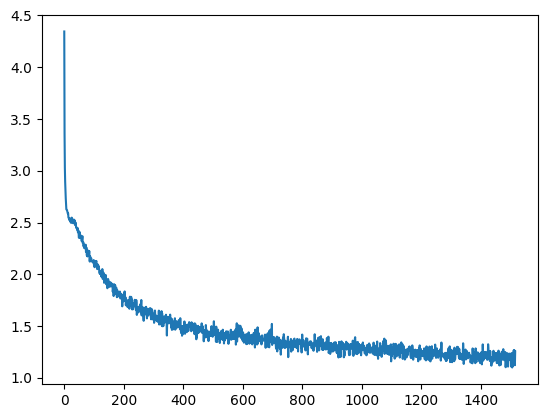

In [12]:
from matplotlib import pyplot as plt
plt.plot(losses)
plt.show()

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F

@torch.no_grad()
def eval_bits_per_char(model, val_ids, block_size=1024, max_batches=200, device=None):
    """
    Computes BPC and PPL on random contiguous slices.
    Assumes ?1 the loss returned by model(x, y) is mean NLL per token.
    """
    model.eval()
    if device is None:
        device = next(model.parameters()).device

    total_nll_nat = 0.0
    total_tokens = 0

    for _ in range(max_batches):
        if len(val_ids) <= block_size + 1:
            break

        start = np.random.randint(0, len(val_ids) - block_size - 1)
        x = torch.tensor(val_ids[start:start+block_size], dtype=torch.long, device=device)[None, :]
        y = torch.tensor(val_ids[start+1:start+block_size+1], dtype=torch.long, device=device)[None, :]

        # IMPORTANT: pass y so the model returns a sequence loss
        logits, loss = model(x, y)

        # If model doesn’t return loss for some reason, compute it safely
        if loss is None:
            # Handle both possible logits shapes
            if logits.dim() == 3 and logits.size(1) == x.size(1):
                # full sequence logits [B, T, V]
                B, T, V = logits.shape
                ce = F.cross_entropy(logits.view(-1, V), y.view(-1), reduction="mean")
                nll_nat = ce.item()
                tokens = T * B
            elif logits.dim() == 2:
                # last-step logits [B, V] -> only evaluate the last target
                ce = F.cross_entropy(logits, y[:, -1], reduction="mean")
                nll_nat = ce.item()
                tokens = logits.size(0)  # B tokens (here 1)
            else:
                raise ValueError(f"Unexpected logits shape: {tuple(logits.shape)}")
        else:
            # ?1 assume this is mean NLL per token (standard)
            nll_nat = float(loss.item())
            tokens = x.numel()  # B * T

        total_nll_nat += nll_nat * tokens
        total_tokens  += tokens

    if total_tokens == 0:
        return float("nan"), float("nan")

    avg_nll_nat = total_nll_nat / total_tokens
    bpc = avg_nll_nat / np.log(2.0)
    ppl = float(np.exp(avg_nll_nat))
    return bpc, ppl,avg_nll_nat

bpc, ppl ,ce = eval_bits_per_char(model, val_ids, block_size=1024, max_batches=200, device=device)
print("BPC:", bpc, "Perplexity:", ppl, "VAL LOSS:", ce)


BPC: 2.314952392104434 Perplexity: 4.975882409954749 VAL LOSS: 1.6046027237176894


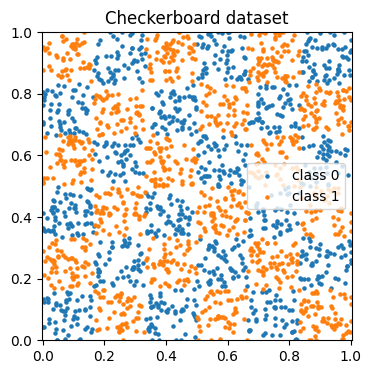

Epoch  100 | base loss: 0.2633 | opt loss: 0.4255
Epoch  200 | base loss: 0.1810 | opt loss: 0.4004
Epoch  300 | base loss: 0.1859 | opt loss: 0.3512
Epoch  400 | base loss: 0.1734 | opt loss: 0.2616
Epoch  500 | base loss: 0.1343 | opt loss: 0.1479


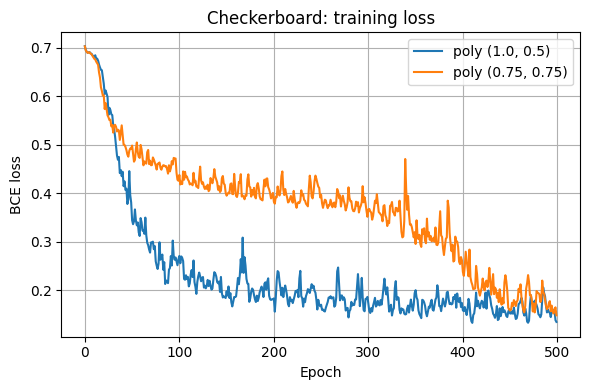

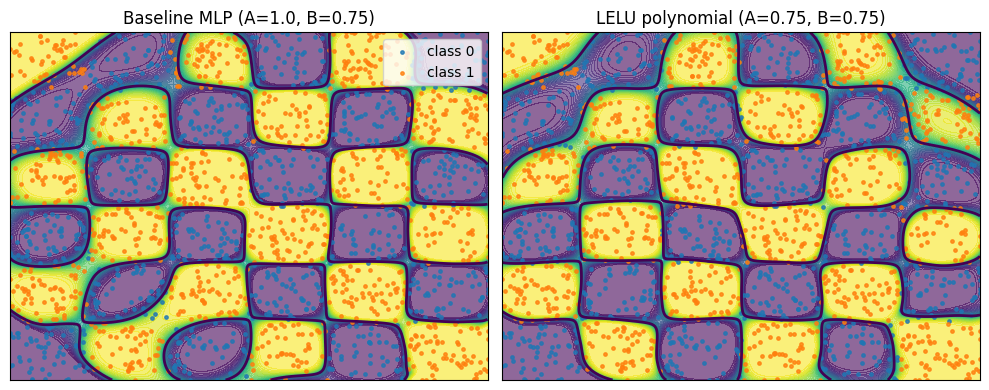

In [ ]:
import math
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(0)

# -------------------------
# 1. Checkerboard dataset
# -------------------------

def make_checkerboard(n_points=2000, n_cells_per_axis=4, noise=0.05, device="cpu"):
    """
    2D checkerboard:
      - sample points uniformly in [0, 1]^2
      - split into n_cells_per_axis x n_cells_per_axis grid
      - label = (i + j) % 2 for cell indices (i, j)
    """
    X = torch.rand(n_points, 2, device=device)  # uniform in [0,1]^2

    # Optionally add small Gaussian noise in coordinate space
    X = X + noise * torch.randn_like(X)
    # keep roughly in [0,1] by clipping
    X = torch.clamp(X, 0.0, 1.0)

    # cell indices
    cell_x = torch.floor(X[:, 0] * n_cells_per_axis).long()
    cell_y = torch.floor(X[:, 1] * n_cells_per_axis).long()

    # clamp to valid range (for points very close to 1 after noise)
    cell_x = torch.clamp(cell_x, 0, n_cells_per_axis - 1)
    cell_y = torch.clamp(cell_y, 0, n_cells_per_axis - 1)

    # Checkerboard labeling: alternating pattern
    y = (cell_x + cell_y) % 2
    y = y.float()

    return X, y

X, y = make_checkerboard(
    n_points=2000,
    n_cells_per_axis=6,  # more cells = finer pattern
    noise=0.02,
    device=device
)

# Visual sanity check
plt.figure(figsize=(4,4))
X_np = X.cpu().numpy()
y_np = y.cpu().numpy()
plt.scatter(X_np[y_np==0,0], X_np[y_np==0,1], s=5, label="class 0")
plt.scatter(X_np[y_np==1,0], X_np[y_np==1,1], s=5, label="class 1")
plt.axis("equal")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.title("Checkerboard dataset")
plt.show()

# -------------------------
# 2. Poly + LELU MLP block
# -------------------------

class PolyLELUBlock(nn.Module):
    def __init__(self, d_model, hidden_multiplier=2,
                 A=1.0, B=0.5, dropout=0.0, bias=True):
        super().__init__()
        self.A = A
        self.B = B
        hidden_dim = hidden_multiplier * d_model

        self.c_fc = nn.Linear(d_model, hidden_dim, bias=bias)
        self.ln = nn.LayerNorm(hidden_dim, elementwise_affine=True)
        self.c_proj = nn.Linear(hidden_dim, d_model, bias=bias)
        self.dropout = nn.Dropout(dropout)

        # LELU scale: logistic CDF with unit variance
        self.scale = math.pi / math.sqrt(3.0)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.A * x**2 + self.B * x**3
        x = self.ln(x)
        x = x * torch.sigmoid(self.scale * x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

# -------------------------
# 3. Checkerboard classifier
# -------------------------

class CheckerNet(nn.Module):
    def __init__(self, A, B, d_model=64):
        super().__init__()
        self.input = nn.Linear(2, d_model)
        self.mlp = PolyLELUBlock(d_model, hidden_multiplier=2,
                                 A=A, B=B, dropout=0.0)
        self.output = nn.Linear(d_model, 1)

    def forward(self, x):
        h = self.input(x)
        h = self.mlp(h)
        out = self.output(h)
        return out.squeeze(-1)

# Baseline vs LELU-derived (A,B)
A_base, B_base = 1.0, 0.75
A_opt,  B_opt  = 0.75, 0.75

torch.manual_seed(42)
model_base = CheckerNet(A_base, B_base).to(device)

torch.manual_seed(42)  # same init pattern, different polynomial
model_opt = CheckerNet(A_opt, B_opt).to(device)

# -------------------------
# 4. Training loop
# -------------------------

criterion = nn.BCEWithLogitsLoss()
opt_base = torch.optim.Adam(model_base.parameters(), lr=3e-3)
opt_opt  = torch.optim.Adam(model_opt.parameters(),  lr=3e-3)

num_epochs = 500
batch_size = 256

N = X.size(0)
loss_history_base = []
loss_history_opt  = []

for epoch in range(num_epochs):
    perm = torch.randperm(N, device=device)
    X_shuffled = X[perm]
    y_shuffled = y[perm]

    epoch_loss_base = 0.0
    epoch_loss_opt  = 0.0

    for i in range(0, N, batch_size):
        xb = X_shuffled[i:i+batch_size]
        yb = y_shuffled[i:i+batch_size]

        # --- baseline ---
        opt_base.zero_grad()
        logits_base = model_base(xb)
        loss_base = criterion(logits_base, yb)
        loss_base.backward()
        opt_base.step()

        # --- optimized ---
        opt_opt.zero_grad()
        logits_opt = model_opt(xb)
        loss_opt = criterion(logits_opt, yb)
        loss_opt.backward()
        opt_opt.step()

        epoch_loss_base += loss_base.item() * xb.size(0)
        epoch_loss_opt  += loss_opt.item() * xb.size(0)

    epoch_loss_base /= N
    epoch_loss_opt  /= N
    loss_history_base.append(epoch_loss_base)
    loss_history_opt.append(epoch_loss_opt)

    if (epoch + 1) % 100 == 0:
        print(
            f"Epoch {epoch+1:4d} | "
            f"base loss: {epoch_loss_base:.4f} | "
            f"opt loss: {epoch_loss_opt:.4f}"
        )

# -------------------------
# 5. Plot training losses
# -------------------------

plt.figure(figsize=(6,4))
plt.plot(loss_history_base, label="poly (1.0, 0.5)")
plt.plot(loss_history_opt,  label=f"poly ({A_opt}, {B_opt})")
plt.xlabel("Epoch")
plt.ylabel("BCE loss")
plt.title("Checkerboard: training loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------
# 6. Plot decision boundaries
# -------------------------

@torch.no_grad()
def plot_decision_boundary(ax, model, title):
    x_min, x_max = 0.0, 1.0
    y_min, y_max = 0.0, 1.0

    grid_x = torch.linspace(x_min, x_max, 300, device=device)
    grid_y = torch.linspace(y_min, y_max, 300, device=device)
    xx, yy = torch.meshgrid(grid_x, grid_y, indexing="xy")
    grid = torch.stack([xx.reshape(-1), yy.reshape(-1)], dim=1)

    logits = model(grid)
    probs = torch.sigmoid(logits).reshape(xx.shape)

    xx_np = xx.cpu().numpy()
    yy_np = yy.cpu().numpy()
    zz_np = probs.cpu().numpy()

    cs = ax.contourf(xx_np, yy_np, zz_np, levels=50, alpha=0.6)
    ax.contour(xx_np, yy_np, zz_np, levels=[0.5], linewidths=2)

    X_np = X.cpu().numpy()
    y_np = y.cpu().numpy()
    ax.scatter(X_np[y_np==0,0], X_np[y_np==0,1], s=6, alpha=0.8, label="class 0")
    ax.scatter(X_np[y_np==1,0], X_np[y_np==1,1], s=6, alpha=0.8, label="class 1")

    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

fig, axes = plt.subplots(1, 2, figsize=(10,4))

plot_decision_boundary(
    axes[0],
    model_base,
    "Baseline MLP (A=1.0, B=0.75)"
)
plot_decision_boundary(
    axes[1],
    model_opt,
    f"LELU polynomial (A={A_opt}, B={B_opt})"
)

axes[0].legend(loc="upper right")
plt.tight_layout()
plt.show()


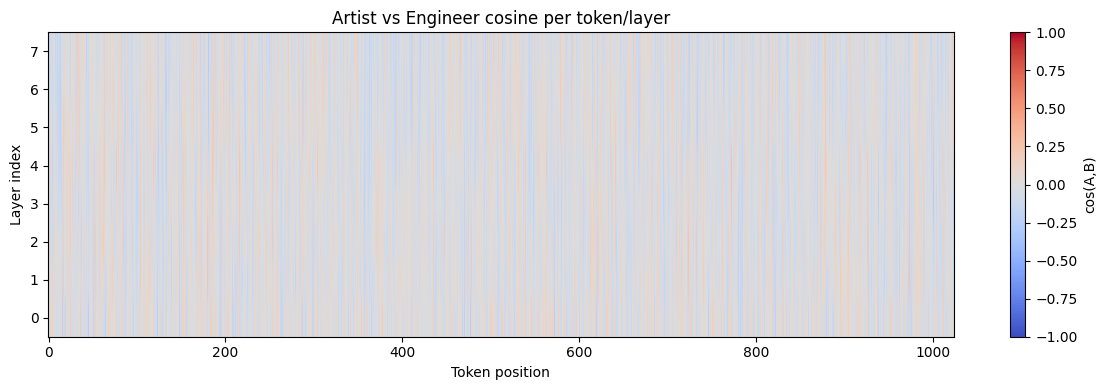

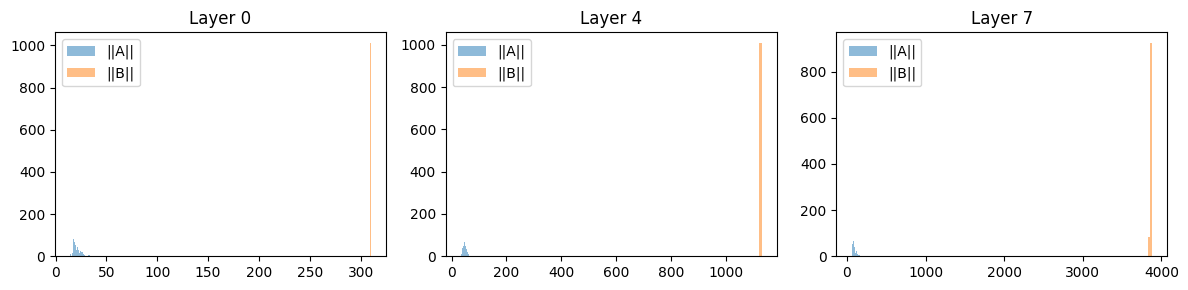

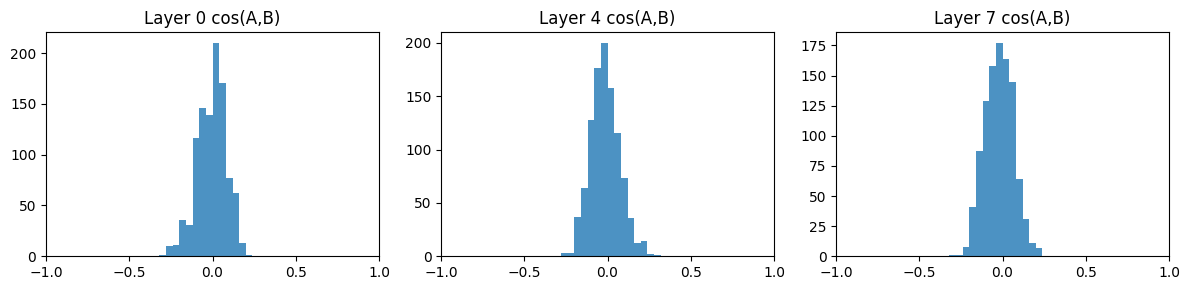

In [ ]:
import torch
import matplotlib.pyplot as plt

@torch.no_grad()
def collect_layer_states(model: GPT, idx: torch.Tensor):
    """
    Runs one forward pass (no grad) through the transformer stack,
    but manually stepping blocks to capture A/B per layer.

    idx: (B, T) long
    returns: list of dicts, one per layer:
        {
          "A": (T, d),   # artist / passed-down half after block
          "B": (T, d),   # engineer / map half after block
        }
    Only the first element in the batch is kept (B=0) for visualization.
    """
    model.eval()
    device = next(model.parameters()).device
    idx = idx.to(device)

    # build initial X exactly like GPT.forward
    x = model._build_initial_x(idx)  # (B, T, 2*d)
    Bsz, T, C = x.shape
    half = C // 2

    layer_states = []

    # step through blocks manually
    for block in model.transformer.h:
        x = block(x)  # (B, T, 2*d)
        # split after this block
        A = x[0, :, :half].detach().cpu()  # (T, d)
        B_map = x[0, :, half:].detach().cpu()  # (T, d)
        layer_states.append({"A": A, "B": B_map})

    return layer_states
def summarize_roles(layer_states):
    """
    For each layer, compute:
      - norm_A(t): ||A_t|| per token
      - norm_B(t): ||B_t|| per token
      - cos_AB(t): cosine similarity between A_t and B_t per token

    Returns a list of per-layer dicts with numpy arrays.
    """
    stats = []
    eps = 1e-8

    for layer_idx, st in enumerate(layer_states):
        A = st["A"]  # (T, d)
        B = st["B"]  # (T, d)

        # norms per token
        norm_A = A.norm(dim=-1)           # (T,)
        norm_B = B.norm(dim=-1)           # (T,)

        # cosine similarity per token
        dot = (A * B).sum(dim=-1)
        cos = dot / (norm_A * norm_B + eps)

        stats.append({
            "norm_A": norm_A.numpy(),
            "norm_B": norm_B.numpy(),
            "cos_AB": cos.numpy(),
        })

    return stats


def plot_cosine_heatmap(stats, title="Cos(A,B) per token and layer"):
    """
    Heatmap: rows = layers, columns = tokens, values = cos(A_t, B_t).
    """
    # assume all layers have same T
    num_layers = len(stats)
    T = stats[0]["cos_AB"].shape[0]

    cos_matrix = np.stack([s["cos_AB"] for s in stats], axis=0)  # (L, T)

    plt.figure(figsize=(12, 4))
    plt.imshow(cos_matrix, aspect="auto", origin="lower", cmap="coolwarm",
               vmin=-1.0, vmax=1.0)
    plt.colorbar(label="cos(A,B)")
    plt.xlabel("Token position")
    plt.ylabel("Layer index")
    plt.title(title)
    plt.tight_layout()
    plt.show()


def plot_norms_hist(stats, layer_indices=None):
    """
    For chosen layers, plot histograms of ||A|| and ||B|| per token.
    """
    if layer_indices is None:
        layer_indices = range(len(stats))

    num_layers = len(layer_indices)
    plt.figure(figsize=(4 * num_layers, 3))

    for i, layer_idx in enumerate(layer_indices):
        s = stats[layer_idx]
        plt.subplot(1, num_layers, i + 1)
        plt.hist(s["norm_A"], bins=50, alpha=0.5, label="||A||")
        plt.hist(s["norm_B"], bins=50, alpha=0.5, label="||B||")
        plt.title(f"Layer {layer_idx}")
        plt.legend()

    plt.tight_layout()
    plt.show()


def plot_cosine_hist(stats, layer_indices=None):
    """
    Histograms of cos(A,B) per token, for selected layers.
    """
    if layer_indices is None:
        layer_indices = range(len(stats))

    num_layers = len(layer_indices)
    plt.figure(figsize=(4 * num_layers, 3))

    for i, layer_idx in enumerate(layer_indices):
        s = stats[layer_idx]
        plt.subplot(1, num_layers, i + 1)
        plt.hist(s["cos_AB"], bins=50, range=(-1, 1), alpha=0.8)
        plt.title(f"Layer {layer_idx} cos(A,B)")
        plt.xlim(-1, 1)

    plt.tight_layout()
    plt.show()


# pick a small batch from your existing loader
model.eval()
xb, yb = next(iter(train_loader))
xb = xb[0]  # unwrap the dataset's extra batch dimension: (B, T)

# collect per-layer A/B states
layer_states = collect_layer_states(model, xb)

# summarize
stats = summarize_roles(layer_states)

# visualize
plot_cosine_heatmap(stats, title="Artist vs Engineer cosine per token/layer")
plot_norms_hist(stats, layer_indices=[0, len(stats)//2, len(stats)-1])
plot_cosine_hist(stats, layer_indices=[0, len(stats)//2, len(stats)-1])


In [ ]:
@torch.no_grad()
def loss_with_B_zeroed_from_start(model: GPT, xb, yb):
    model.eval()
    device = next(model.parameters()).device
    xb, yb = xb.to(device), yb.to(device)

    # 1. Build initial X
    x = model._build_initial_x(xb)  # (B, T, 2*d)
    Bsz, T, C = x.shape
    half = C // 2

    # 2. Zero engineer half everywhere at input
    A0 = x[..., :half]
    B0 = torch.zeros_like(A0)
    x = torch.cat([A0, B0], dim=-1)

    # 3. Run through blocks as usual
    for block in model.transformer.h:
        x = block(x)

    # 4. Final artist-only readout (as in your forward)
    A = x[..., :half]
    x_final = model.transformer.ln_f(A)
    logits = model.lm_head(x_final)
    loss = F.cross_entropy(
        logits.view(-1, logits.size(-1)),
        yb.view(-1),
        ignore_index=-1,
    )
    return loss.item()

xb, yb = next(iter(train_loader))
xb, yb = xb[0], yb[0]

with torch.no_grad():
    base_logits, base_loss = model(xb, yb)
    loss_B_from_start = loss_with_B_zeroed_from_start(model, xb, yb)

print("base loss                :", base_loss.item())
print("loss with B=0 from start :", loss_B_from_start)



base loss                : 1.0714809894561768
loss with B=0 from start : 1.0734177827835083


'''
Negative log-likelihood (NLL): The metric underneath both BPC and PPL is the average negative log probability assigned to the true next token. Lower NLL means the model is assigning higher probability to correct targets → better performance.

BPC = NLL in bits per token. Lower BPC means fewer bits are needed to encode the text, i.e. the model compresses language better. A perfect model would reach 0.0 BPC.

PPL = exp(NLL). It represents the "effective branching factor" (how many equally likely next tokens the model is as uncertain between). Lower perplexity means the model is more confident and accurate. A perfect model would reach 1.0 PPL.
Models with <100k parameters usually collapse to gibberish or never beat 5-gram.
BPC of NGRAM is ~3.5-4
'''

In [ ]:
import pickle
def decode_chars(token_ids, itos):
    """
    Decodes a list of character token IDs into a string.
    """
    return ''.join([itos[i] for i in token_ids])

def encode_chars(text, stoi):
    """
    Encodes a string into a list of token IDs, one per character.
    """
    return [stoi.get(c, 0) for c in text]


import torch

def decode_sequence_char(
    model, stoi, itos, prompt, max_new_tokens=100, block_size=256,
    use_fenchel=False, tau=1.0, fenchel_iters=3, temperature=1.0
):
    model.eval()
    device = next(model.parameters()).device

    max_ctx = int(block_size)

    # ?1 pad token: try space, fallback to 0
    space_id = stoi.get(' ', 0)

    # encode prompt
    start_ids = torch.tensor([encode_chars(prompt, stoi)], dtype=torch.long, device=device)

    # If prompt is longer than block, keep the last block_size chars
    if start_ids.size(1) > max_ctx:
        start_ids = start_ids[:, -max_ctx:]

    # Left-pad to exactly block_size so the first pass sees a full window
    pad_len = max(0, max_ctx - start_ids.size(1))
    if pad_len > 0:
        pad = torch.full((1, pad_len), space_id, dtype=torch.long, device=device)
        idx = torch.cat([pad, start_ids], dim=1)  # shape [1, block_size]
    else:
        idx = start_ids  # already block_size or longer (truncated above)

    initial_pad_len = pad_len  # for stripping at the end

    # generation loop
    with torch.no_grad():
        for _ in range(max_new_tokens):
            context = idx[:, -max_ctx:]  # always feed the last block_size tokens
            logits, _ = model(context, None)
            last_logits = logits[:, -1, :]
            if temperature != 1.0:
                last_logits = last_logits / float(temperature)
            probs = torch.softmax(last_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)  # [1,1]
            idx = torch.cat([idx, next_token], dim=1)

    # drop the initial left-pad when decoding to text
    out_tokens = idx[0, initial_pad_len:].tolist()
    return decode_chars(out_tokens, itos)


with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi = meta["stoi"]
itos = meta["itos"]

prompt = "ROMEO: Juliet, do you love me?  JULIET:"
generated = decode_sequence_char(
    model=model,
    stoi=stoi,
    itos=itos,
    prompt=prompt,
    max_new_tokens=1024,
    block_size=1024,
    use_fenchel=False,
    tau=1.5,
    fenchel_iters=2,
    temperature=1.0
)

print(generated)


ROMEO: Juliet, do you love me?  JULIET:
O, fie! to entrancot too together;
You are forbeash of some combar after
Than my thoughts, thus, eveIuty fair.

QUEEN ELIZABETH:
Good mother, Rome, I fear him for the feast
Of secretly on the state enmity.

CATESBY:
If I dare no accusa, poison, in good house, no.
If you submition. But you sing that we have could wids
ever this traitor, a sudden the horse, tempted us
His celebeians touch'd his hands. You must lends our guides, I will relive,
Uncle you to keep as thou departure medicable
By ale as term him quenches. Hark you to comfort
To uchen with cheap.

CERIOLA:
'Tis not so.

LUKE VINbIO:
Traitor, good sir.

MERCUTIO:
You shall see you inforce, have we contently.

ISABELLA:
Ho; though in I oath? play no less? peace.
Happy husband's tomb, the cause
of this news:
My brother, is the warnal, 'Come: satisfy?

CATESBY:
I sit unto the little good to you; for it is
Kept his wife and so went;
Nurselbour lives your musicians and he hammet,
The eag of dan

In [ ]:
import pickle
def decode_chars(token_ids, itos):
    """
    Decodes a list of character token IDs into a string.
    """
    return ''.join([itos[i] for i in token_ids])

def encode_chars(text, stoi):
    """
    Encodes a string into a list of token IDs, one per character.
    """
    return [stoi.get(c, 0) for c in text]


import torch

def decode_sequence_char(
    model, stoi, itos, prompt, max_new_tokens=100, block_size=256,
    use_fenchel=False, tau=1.0, fenchel_iters=3, temperature=1.0
):
    model.eval()
    device = next(model.parameters()).device

    max_ctx = int(block_size)

    # ?1 pad token: try space, fallback to 0
    space_id = stoi.get(' ', 0)

    # encode prompt
    start_ids = torch.tensor([encode_chars(prompt, stoi)], dtype=torch.long, device=device)

    # If prompt is longer than block, keep the last block_size chars
    if start_ids.size(1) > max_ctx:
        start_ids = start_ids[:, -max_ctx:]

    # Left-pad to exactly block_size so the first pass sees a full window
    pad_len = max(0, max_ctx - start_ids.size(1))
    if pad_len > 0:
        pad = torch.full((1, pad_len), space_id, dtype=torch.long, device=device)
        idx = torch.cat([pad, start_ids], dim=1)  # shape [1, block_size]
    else:
        idx = start_ids  # already block_size or longer (truncated above)

    initial_pad_len = pad_len  # for stripping at the end

    # generation loop
    with torch.no_grad():
        for _ in range(max_new_tokens):
            context = idx[:, -max_ctx:]  # always feed the last block_size tokens
            logits, _ = model(context, None)
            last_logits = logits[:, -1, :]
            if temperature != 1.0:
                last_logits = last_logits / float(temperature)
            probs = torch.softmax(last_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)  # [1,1]
            idx = torch.cat([idx, next_token], dim=1)

    # drop the initial left-pad when decoding to text
    out_tokens = idx[0, initial_pad_len:].tolist()
    return decode_chars(out_tokens, itos)


with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi = meta["stoi"]
itos = meta["itos"]

prompt = "ROMEO: Juliet, do you love me?  JULIET:"
generated = decode_sequence_char(
    model=model,
    stoi=stoi,
    itos=itos,
    prompt=prompt,
    max_new_tokens=1024,
    block_size=1024,
    use_fenchel=False,
    tau=1.5,
    fenchel_iters=2,
    temperature=0.001
)

print(generated)


ROMEO: Juliet, do you love me?  JULIET:
I am the send the sent to the sent to the sent to the sent to the sentence
The shall be the sent to the sent to the sentence,
And the shall be so make the sent to the sentence
The shall be the sent to the sent to the sentence,
And the shall be so make the sent to the sent to the sent to the sent to the sent to the sent to the sent to the sent to the sent to the sent to the sent to the sentence,
And so much as the state of the shall be soul,
And so much as the state of the shall be the sent to the sent to the sent to the sent to the sent to the sent to the sent to the sent to the sent to the sentence
The shall be so make the sent to the sent to the sentence,
And the shall be so make the sent to the sent to the sent to the sent to the sent to the sent to the sent to the sent to the sentence,
And the shall the state of the should soul,
And so much as the state of the shall be soul,
And so much as the straight the shall be soul,
And so much as the st

In [ ]:
import pickle
def decode_chars(token_ids, itos):
    """
    Decodes a list of character token IDs into a string.
    """
    return ''.join([itos[i] for i in token_ids])

def encode_chars(text, stoi):
    """
    Encodes a string into a list of token IDs, one per character.
    """
    return [stoi.get(c, 0) for c in text]


import torch

def decode_sequence_char(
    model, stoi, itos, prompt, max_new_tokens=100, block_size=256,
    use_fenchel=False, tau=1.0, fenchel_iters=3, temperature=1.0
):
    model.eval()
    device = next(model.parameters()).device

    max_ctx = int(block_size)

    # ?1 pad token: try space, fallback to 0
    space_id = stoi.get(' ', 0)

    # encode prompt
    start_ids = torch.tensor([encode_chars(prompt, stoi)], dtype=torch.long, device=device)

    # If prompt is longer than block, keep the last block_size chars
    if start_ids.size(1) > max_ctx:
        start_ids = start_ids[:, -max_ctx:]

    # Left-pad to exactly block_size so the first pass sees a full window
    pad_len = max(0, max_ctx - start_ids.size(1))
    if pad_len > 0:
        pad = torch.full((1, pad_len), space_id, dtype=torch.long, device=device)
        idx = torch.cat([pad, start_ids], dim=1)  # shape [1, block_size]
    else:
        idx = start_ids  # already block_size or longer (truncated above)

    initial_pad_len = pad_len  # for stripping at the end

    # generation loop
    with torch.no_grad():
        for _ in range(max_new_tokens):
            context = idx[:, -max_ctx:]  # always feed the last block_size tokens
            logits, _ = model(context, None)
            last_logits = logits[:, -1, :]
            if temperature != 1.0:
                last_logits = last_logits / float(temperature)
            probs = torch.softmax(last_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)  # [1,1]
            idx = torch.cat([idx, next_token], dim=1)

    # drop the initial left-pad when decoding to text
    out_tokens = idx[0, initial_pad_len:].tolist()
    return decode_chars(out_tokens, itos)


with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi = meta["stoi"]
itos = meta["itos"]

prompt = "ROMEO: Juliet, do you love me?  JULIET:"
generated = decode_sequence_char(
    model=model,
    stoi=stoi,
    itos=itos,
    prompt=prompt,
    max_new_tokens=1024,
    block_size=1024,
    use_fenchel=False,
    tau=1.5,
    fenchel_iters=2,
    temperature=0.5
)

print(generated)


ROMEO: Juliet, do you love me?  JULIET:
I have the corrust and made no shall say here,
I had so more in my heart with her state:
If my son, with a life is a many of so soul with true,
Who heaven the arm and their wife to my foe heart
And the charish to the father the hath a service,
And let his son the prayer was be me some father love.

First Citizens: and made the shake a mother,
I have some prince ope brought to be a mothers
And that may he intercans, that was the shall sent friends
prince them shall slay the wish make state.

MERIANIO:
You have stay, and so male to me all the call born the hath a wall
For how slain'd my son him and in this heart
That is a glority and so more in the provost:
And he are no world, that a secret some more,
Whose graciman is a cherken and graine of the state,
That I see and or with the prepare assure strain,
And slaughter me may be of his reason to speak for our grown thee,
And are conceit of my father, and my come
Whom he shall make the master to the m

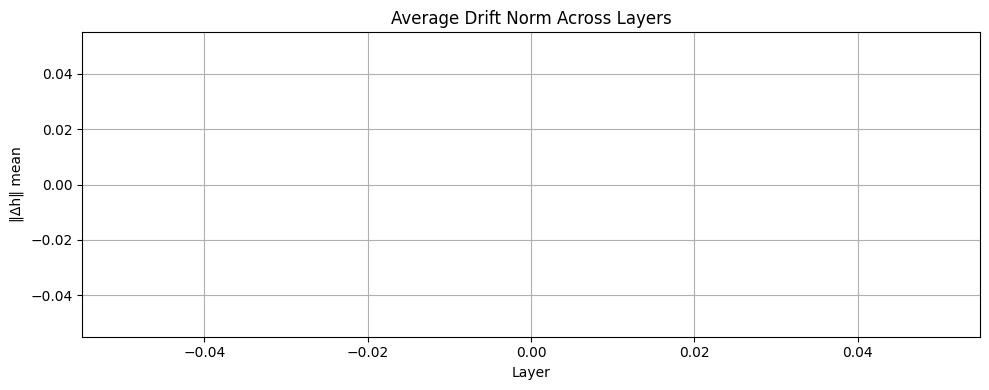

Jacobian rank (final token, projected): 66


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad
'''
     def forward(self, idx, targets=None):
        device = idx.device
        b, T = idx.size()

        # forward the GPT model itself
        x = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)

        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)

            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)

        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss

'''


@torch.no_grad()
def compute_drift_trajectories(model, idx, pad_token_id=None):
    """
    Drift vectors Δh_l = h_{l+1} - h_l aligned to the shrinking time axis.
    idx: [B, T_visible]
    pad_token_id: pad token id to prepend once (?1 default=0 if None)
    returns: list of arrays, one per layer-gap, each shaped [B]
    """
    model.eval()
    device = idx.device
    B, T_vis = idx.size()

    tok = idx
    # forward the GPT model itself


    # token + pos emb
    x = model.transformer.wte(tok)
    layers = []
    with torch.no_grad():
        for block in model.transformer.h:
            x = block(x)             # time shrinks by n_head each block (per your setup)
            layers.append(x.clone()) # store aligned outputs

    # compute drifts with alignment: previous tail matches current length
    drifts = []
    for i in range(len(layers) - 1):
        a = layers[i]
        b = layers[i + 1]
        a_aligned = a[:, -b.size(1):, :]
        d = (b - a_aligned)
        drifts.append(d.norm(dim=-1).mean(dim=-1).cpu().numpy())  # [B]
    return drifts


def compute_jacobian_rank(model, idx, projection_dim=324, pad_token_id=None):
    """
    Rank of Jacobian d logits_proj(T_final) / d emb(T_input_last) with pad-once and shrink.
    idx: [B, T_visible]
    pad_token_id: pad token id to prepend once (?2 default=0 if None)
    """
    model.eval()
    device = idx.device
    B, T_vis = idx.size()

    tok = idx

    # embeddings with grad
    tok_emb = model.transformer.wte(tok)
    emb = tok_emb
    def forward_emb(x):
        for block in model.transformer.h:
            x = block(x)             # time shrinks each block
        x = model.transformer.ln_f(x)
        logits = model.lm_head(x)    # [B, T_out, V]
        return logits[:, -1, :projection_dim]  # final token after shrink, projected

    output = forward_emb(emb)         # [B, P]
    jac_rows = []
    for i in range(output.shape[-1]):
        go = torch.zeros_like(output)
        go[:, i] = 1.0
        gi = grad(output, emb, grad_outputs=go, retain_graph=True)[0]  # [B, T_all, C]
        jac_rows.append(gi[:, -1, :].detach().cpu().numpy().squeeze()) # grad w.r.t. last input step
    J = np.stack(jac_rows, axis=0)     # [P, C]
    return int(np.linalg.matrix_rank(J))

def plot_drift(drift_norms):
    """
    Plot average drift norm per layer.
    """
    plt.figure(figsize=(10, 4))
    plt.plot([np.mean(d) for d in drift_norms], marker='o')
    plt.title("Average Drift Norm Across Layers")
    plt.xlabel("Layer")
    plt.ylabel("‖Δh‖ mean")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example usage
input_ids = torch.randint(0, model.config.vocab_size, (1, model.config.block_size)).to(device)

jac_rank = compute_jacobian_rank(model, input_ids)

drift_norms = compute_drift_trajectories(model, input_ids)
plot_drift(drift_norms)

print("Jacobian rank (final token, projected):", jac_rank)


In [ ]:
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def collect_drift_matrix(model, idx, pad_token_id=None):
    """
    Build a drift matrix by stacking aligned per-layer deltas:
      Δ_l = h_{l+1} - tail_match(h_l)
    Tail-match aligns time since each block trims from the left.

    idx: [B, T_visible]
    pad_token_id: ?1 left-pad token id; default 0 if None
    returns: torch.FloatTensor [N, D] on CPU where N = sum_l B * T_l
    """
    model.eval()
    device = idx.device
    B, T_vis = idx.size()

    tok = idx

    # 2) embed like forward() does
    x = model.transformer.wte(tok)
    # 3) collect per-block states (time shrinks each block)
    states = []
    with torch.no_grad():
        for block in model.transformer.h:
            x = block(x)     # length shrinks by your per-layer trim
            states.append(x.clone())

    # 4) aligned drifts: match tail of h_l to h_{l+1}
    drift_chunks = []
    for i in range(len(states) - 1):
        a = states[i]       # [B, T_a, C]
        b = states[i + 1]   # [B, T_b, C], T_b <= T_a
        a_aligned = a[:, -b.size(1):, :]     # tail-match
        d = (b - a_aligned).reshape(-1, b.size(-1))  # [B*T_b, C]
        drift_chunks.append(d.cpu())

    drift_matrix = torch.cat(drift_chunks, dim=0) if drift_chunks else torch.empty(0, x.size(-1))
    return drift_matrix  # [N, D] on CPU


def run_drift_pca(drift_matrix, k=40):
    """
    PCA on drift samples. drift_matrix can be torch.Tensor [N, D] (CPU or CUDA) or np.ndarray.
    """
    if isinstance(drift_matrix, torch.Tensor):
        drift_np = drift_matrix.detach().cpu().numpy()
    else:
        drift_np = np.asarray(drift_matrix)
    k = min(k, drift_np.shape[0], drift_np.shape[1])  # guard
    pca = PCA(n_components=k)
    pca.fit(drift_np)
    explained = pca.explained_variance_ratio_
    return explained, pca


def plot_explained_variance(explained):
    plt.figure(figsize=(8, 4))
    plt.plot(np.cumsum(explained) * 100, marker='o')
    plt.xlabel("Principal Component")
    plt.ylabel("Cumulative Variance Explained (%)")
    plt.title("Drift Trajectory PCA: Explained Variance")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
from sklearn.mixture import GaussianMixture
import seaborn as sns

def get_projected_residuals(drift_matrix, pca):
    """
    Project Δh onto PCA space and get residuals.
    """
    proj = pca.transform(drift_matrix.numpy())
    recon = pca.inverse_transform(proj)
    residuals = drift_matrix.numpy() - recon
    return proj, residuals

def fit_gmm(proj_data, k=4):
    """
    Fit GMM to PCA-projected drift vectors to identify latent regimes.
    """
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=0)
    gmm.fit(proj_data)
    labels = gmm.predict(proj_data)
    return gmm, labels

def plot_gmm_clusters(proj_data, labels):
    """
    Plot GMM clustering over first 2 PCA components.
    """
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=proj_data[:, 0], y=proj_data[:, 1], hue=labels, palette="tab10", s=10)
    plt.title("Latent Regimes from Drift PCA (GMM Clusters)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
# Inputs
input_ids = torch.randint(0, model.config.vocab_size, (1, model.config.block_size)).to(device)

# Drift matrix
drift_matrix = collect_drift_matrix(model, input_ids)

# PCA and variance
explained, pca = run_drift_pca(drift_matrix, k=40)
plot_explained_variance(explained)

# Residuals and GMM regime fit
proj, residuals = get_projected_residuals(drift_matrix, pca)
gmm, labels = fit_gmm(proj, k=4)
plot_gmm_clusters(proj, labels)


ValueError: Found array with 0 sample(s) (shape=(0, 128)) while a minimum of 1 is required by PCA.

[Baseline] Val loss: 1.4010

--- Per-Layer Ablation Report ---
Ablate Layer  0: Loss = 1.4679 | Δ = 0.0669
Ablate Layer  1: Loss = 1.4123 | Δ = 0.0113
Ablate Layer  2: Loss = 1.4542 | Δ = 0.0533
Ablate Layer  3: Loss = 1.4390 | Δ = 0.0380
Ablate Layer  4: Loss = 1.4497 | Δ = 0.0487
Ablate Layer  5: Loss = 1.4327 | Δ = 0.0318


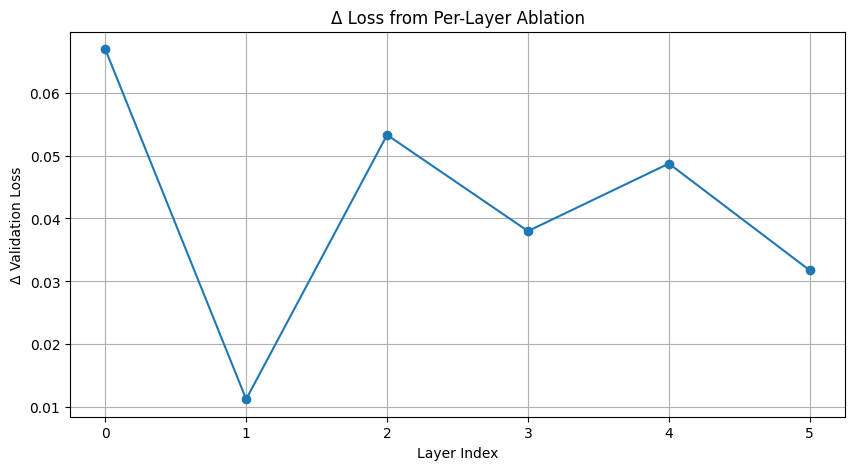

In [ ]:
import matplotlib.pyplot as plt
from contextlib import contextmanager
import os
import pickle
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch
from torch import nn
import torch.nn.functional as F

# ==============================
# 🔁 LAYER ABLATION LOGIC BLOCK
# =============================

# === Config ===
data_dir = "./babylm_char_tokenized"  # <- char-tokenized data
block_size = 1024
batch_size = 1
# === Load tokenizer metadata ===
with open(os.path.join(data_dir, 'meta.pkl'), 'rb') as f:
    meta = pickle.load(f)
vocab_size = meta['vocab_size']

# === Load mmap data (char-level tokens, uint16) ===
train_ids = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
val_ids   = np.memmap(os.path.join(data_dir, 'val.bin'),   dtype=np.uint16, mode='r')

# === Efficient GPU Batch Sampler ===
class GPUBatchDataset(Dataset):
    def __init__(self, mmap_file, block_size, batch_size, device):
        self.data = mmap_file
        self.block_size = block_size
        self.batch_size = batch_size
        self.device = device
        self.total = len(self.data) - block_size - 1

    def __len__(self):
        return self.total // self.batch_size

    def __getitem__(self, idx):
        X = np.empty((self.batch_size, self.block_size), dtype=np.int64)
        Y = np.empty((self.batch_size, self.block_size), dtype=np.int64)
        for i in range(self.batch_size):
            start = np.random.randint(0, self.total // self.block_size) * self.block_size
            X[i] = self.data[start : start + self.block_size]
            Y[i] = self.data[start + 1 : start + 1 + self.block_size]
        return (
            torch.from_numpy(X).to(self.device, non_blocking=True),
            torch.from_numpy(Y).to(self.device, non_blocking=True)
        )

val_dataset = GPUBatchDataset(val_ids, block_size, batch_size=1, device=device)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)
criterion = nn.CrossEntropyLoss()
losses = []
@contextmanager
def layer_ablation_context(model, layers_to_ablate):
    """Context manager that safely ablates selected layers by overriding their .forward."""
    original_forwards = [block.forward for block in model.transformer.h]

    def make_ablation_forward(index, original_fn):
        def ablated_forward(x):
            out = original_fn(x)
            return out
        return ablated_forward

    try:
        for i, block in enumerate(model.transformer.h):
            if i in layers_to_ablate:
                model.transformer.h[i].forward = make_ablation_forward(i, original_forwards[i])
        yield
    finally:
        # Always restore the original forwards
        for i, block in enumerate(model.transformer.h):
            model.transformer.h[i].forward = original_forwards[i]

@torch.no_grad()
def eval_epoch(max_batches=50):
    model.eval()
    total_loss = 0
    for i, (xb, yb) in enumerate(val_loader):
        if i >= max_batches:
            break
        xb, yb = xb[0], yb[0]
        logits, _ = model(xb, yb)
        B, T, V = logits.shape
        total_loss += criterion(logits.view(B * T, V),
                                yb.view(B * T)).item()
    return total_loss / max_batches

# ---- Evaluate baseline without any ablation ----
with layer_ablation_context(model, layers_to_ablate=set()):
    baseline_val_loss = eval_epoch()
print(f"[Baseline] Val loss: {baseline_val_loss:.4f}")

# ---- Run per-layer ablation safely ----
print("\n--- Per-Layer Ablation Report ---")
results = []
for i in range(model.config.n_layer):
    with layer_ablation_context(model, layers_to_ablate={i}):
        loss = eval_epoch()
    delta = loss - baseline_val_loss
    results.append((i, loss, delta))
    print(f"Ablate Layer {i:2d}: Loss = {loss:.4f} | Δ = {delta:.4f}")

# ---- Plotting ----
layer_ids = [i for i, _, _ in results]
delta_vals = [delta for _, _, delta in results]

plt.figure(figsize=(10, 5))
plt.plot(layer_ids, delta_vals, marker='o')
plt.title("Δ Loss from Per-Layer Ablation")
plt.xlabel("Layer Index")
plt.ylabel("Δ Validation Loss")
plt.grid(True)
plt.show()


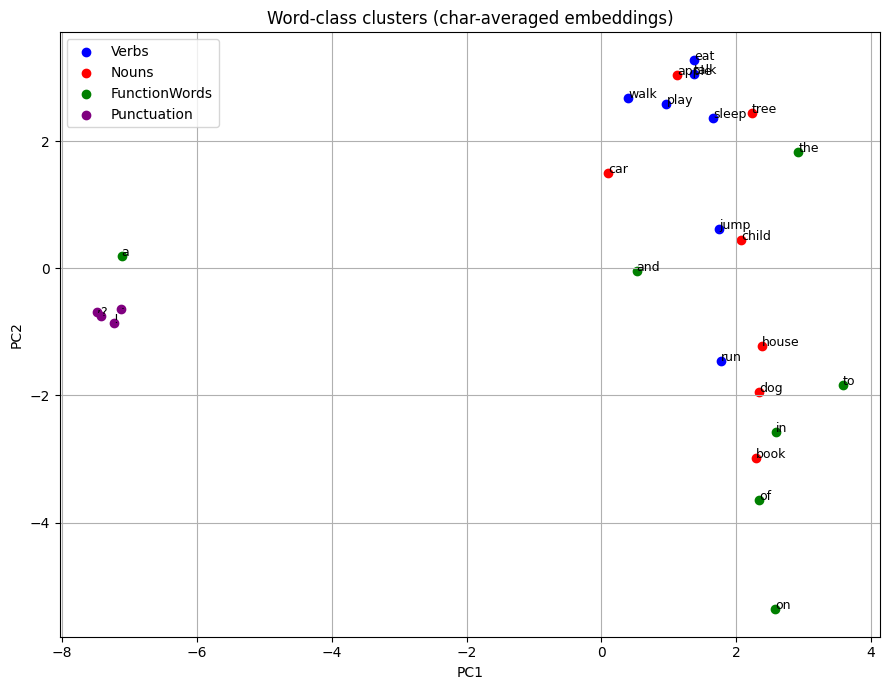

In [ ]:
import torch, pickle, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# ---------- load vocab ----------
with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi, itos = meta["stoi"], meta["itos"]

# ---------- model bits ----------
device = next(model.parameters()).device
model.eval()                      # <— turn off dropout everywhere
wte = model.transformer.wte
wte.eval()

@torch.no_grad()
def get_char_embedding(word):
    ids = [stoi[c] for c in word if c in stoi]
    if len(ids) < 2:              # ← need ≥2 chars for HailFire geometry
        return None
    with torch.no_grad():
        t = torch.tensor(ids, device=device).unsqueeze(0)      # [1, T]
        emb = model.transformer.wte(t).mean(dim=1).squeeze(0)                    # (d,)
        return emb.cpu().numpy()

# ---------- categories ----------
categories = {
    "Verbs":        ["play","run","eat","sleep","jump","talk","walk"],
    "Nouns":        ["dog","tree","car","book","child","house","apple"],
    "FunctionWords":["the","and","in","on","to","of","a   "],
    "Punctuation":  [".    ",",    ","!    ","?    "],
}

# ---------- gather ----------
vecs, labels, words = [], [], []
for cat, wl in categories.items():
    for w in wl:
        v = get_char_embedding(w)
        if v is not None:
            vecs.append(v)
            labels.append(cat)
            words.append(w)

vecs = np.stack(vecs)             # ← now guaranteed rectangular

# ---------- PCA ----------
proj = PCA(n_components=2).fit_transform(vecs)

# ---------- plot ----------
colors = dict(Verbs="blue", Nouns="red",
              FunctionWords="green", Punctuation="purple")

plt.figure(figsize=(9,7))
for cat in categories:
    idx = [i for i,l in enumerate(labels) if l==cat]
    plt.scatter(proj[idx,0], proj[idx,1], label=cat, color=colors[cat])
    for i in idx:
        plt.text(proj[i,0], proj[i,1], words[i], fontsize=9)

plt.title("Word-class clusters (char-averaged embeddings)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()


In [24]:
torch.save(model.state_dict(), 'model_state.pt')